In [1]:
import math
import random
import numpy as np
from collections import deque
import time

import gymnasium as gym
from gymnasium.wrappers import FrameStackObservation as FrameStack
from gymnasium.wrappers import AtariPreprocessing
from gymnasium.wrappers import NumpyToTorch
from gymnasium.wrappers import RecordEpisodeStatistics


import matplotlib
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from collections import namedtuple, deque
from operator import itemgetter

import ale_py

In [15]:
# if GPU is to be used
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

In [16]:
frames_stacked = 4

gym.register_envs(ale_py)

#game = "ALE/Breakout-v5"
game = "ALE/Pong-v5"

terminal_on_life_loss = False
scale_obs = True

env = NumpyToTorch(FrameStack(AtariPreprocessing(RecordEpisodeStatistics(gym.make(game)), frame_skip=1, terminal_on_life_loss=terminal_on_life_loss, scale_obs=scale_obs), frames_stacked), device=device)

num_actions = env.action_space.n
frame_shape = env.observation_space.shape

In [17]:
class DQN(nn.Module):
    def __init__(self, input_shape, num_outputs):
        super(DQN, self).__init__()

        self.input_shape = input_shape
        self.num_outputs = num_outputs

        self.conv_layers = nn.Sequential(
            nn.Conv2d(self.input_shape[0], 32, kernel_size=8, stride=4),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )

        conv_output_len = int(np.prod(self.conv_layers(torch.zeros(1, *input_shape)).size()))

        self.fc_layers = nn.Sequential(
            nn.Linear(conv_output_len,512),
            nn.ReLU(),
            nn.Linear(512,256),
            nn.ReLU(),
            nn.Linear(256, self.num_outputs)
        )
        conv_test = self.conv_layers(torch.zeros(1, *input_shape))

    def forward(self, x):

        conv_out = self.conv_layers(x)
        return self.fc_layers(conv_out.flatten(1))

In [20]:
args = env.reset()
state = args[0]
input_shape = state.shape

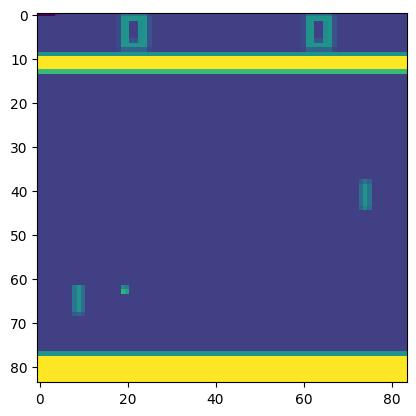

In [21]:
for _ in range(10): state, *_ = env.step(1)
plt.imshow(state[3].cpu().numpy())

In [22]:
model = DQN(input_shape=input_shape, num_outputs=num_actions)

# Create policy and target network.
policy_net = DQN(input_shape=input_shape, num_outputs=num_actions).to(device)
target_net = DQN(input_shape=input_shape, num_outputs=num_actions).to(device)

target_net.load_state_dict(policy_net.state_dict())

with torch.no_grad():
    stateValues = policy_net(state.unsqueeze(0))

stateValues

tensor([[-0.0534, -0.0850, -0.1207, -0.0079, -0.0725, -0.0588]])

In [23]:
# Hyperparameters
alpha = 1e-4  # learning rate
gamma = 0.99 # Discount fator

# Optimiser and loss function
optimiser = optim.Adam(policy_net.parameters(), lr=alpha, amsgrad=True)

In [ ]:
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state'))
class ReplayMemory(object):

    def __init__(self, capacity, batchSize):
        self.maxCapacity = capacity
        self.memory = deque([], maxlen=capacity)
        self.batchSize = batchSize

    def push(self, state, action, reward, nextState):
        self.memory.append(Transition(state, action, reward, nextState))

    def sample(self):
        return random.sample(self.memory, self.batchSize)

    def replay(self):

        if(len(self.memory) < self.batchSize): return

        minibatch = self.sample()

        batch = Transition(*zip(*minibatch))

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)

        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None]).to(device)
        state_batch = torch.cat(batch.state).to(device)
        action_batch = torch.cat(batch.action).to(device)
        reward_batch = torch.cat(batch.reward).to(device)

        next_state_values = torch.zeros(self.batchSize, device=device)

        with torch.no_grad():
            next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values


        state_action_values = policy_net(state_batch).gather(1, action_batch)



        # Compute the expected Q values
        expected_state_action_values = (next_state_values*gamma) + reward_batch


        # Compute Huber loss
        optimiser.zero_grad()
        criterion = nn.HuberLoss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
        #loss.requires_grad = True
        loss.backward()
        # Register backward hook
        for p in policy_net.parameters(): p.grad.data.clamp_(-1, 1)
        optimiser.step()



In [ ]:
# Replay memory parameters
capacity = 100000
batchSize = 32
memory = ReplayMemory(capacity=capacity, batchSize=batchSize)

In [ ]:
import os
import pickle

episodes = 2001
verbose = True
steps = 0
verboseEpisode = 50
timesteps = 0
updateEvery = 1500

EPSILON_START=1.0
EPSILON_END=0.02
EPSILON_DECAY=10000

episodeRewards = []
os.makedirs('models', exist_ok=True)
stats = {}

for episode in range(episodes):
  state, _ = env.reset()
  rewards = 0
  terminated, truncated = False, False
  state = state.unsqueeze(0)

  while not terminated and not truncated:

    epsilon = np.interp(steps, [0, EPSILON_DECAY], [EPSILON_START, EPSILON_END])

    # Explore
    if(random.uniform(0,1) <= epsilon): action = torch.tensor([[env.action_space.sample()]], device=device)

    # Exploit
    else:
        with torch.no_grad():
            q_values = policy_net(state)
            action = torch.argmax(policy_net(state), dim=1).unsqueeze(0)

    steps += 1

    nextState, reward, terminated, truncated, info = env.step(action.item())
    nextState = nextState.unsqueeze(0)

    if(terminated or truncated):
      nextState = None
      stats[episode] = info
    rewards += reward
    memory.push(state, action, torch.tensor([reward], device=device), nextState)


    memory.replay()

    state = nextState

    if(steps%updateEvery == 0): target_net.load_state_dict(policy_net.state_dict())


  episodeRewards.append(rewards)
  if(verbose and episode%verboseEpisode == 0):
    #print(f"Episode: {episode}, Current avg reward: {np.mean(episodeRewards[-verboseEpisode:])}")
    torch.save(target_net.state_dict(), 'models/model_'+str(episode)+'.pt')

with open('stats.pkl', 'wb') as f:
  pickle.dump(stats, f)
